In [50]:
try:
    import gensim
except ModuleNotFoundError:
    !pip install gensim
    
from gensim.models import Word2Vec
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim.models.word2vec import LineSentence
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report

import multiprocessing
import os

In [51]:
try:
    import sklearn
except ModuleNotFoundError:
    !pip install scikit-learn

In [52]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Yera\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Yera\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Yera\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [53]:
import pandas as pd
import numpy as np
import re

In [54]:
df = pd.read_csv("IMDB_Dataset.csv")
df['review'] = df['review'].apply(lambda x: re.sub('<br />', ' ', x))
df['review'] = df['review'].apply(lambda x: re.sub(',', '', x))

In [55]:
tokenized_reviews = [review.split() for review in df['review']]
word2vec_model = Word2Vec(sentences=tokenized_reviews, vector_size=100, window=5, min_count=5, sg=0, negative=5, epochs=10)

In [56]:
corpus = []

# Tokenize the text, remove stopwords, and lemmatize the text
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
for review in df['review']:
    tokens = word_tokenize(review.lower())
    processed_tokens = [lemmatizer.lemmatize(word) for word in tokens if word.isalnum() and word not in stop_words]
    corpus.append(processed_tokens)

# Save the processed data back to the CSV file
df.to_csv("IMDB_processed.csv", index=False)

In [57]:
print(len(corpus))

50000


In [58]:
tagged_corpus = [TaggedDocument(words=doc, tags=[str(i)]) for i, doc in enumerate(corpus)]

cores = multiprocessing.cpu_count()
model = Doc2Vec(vector_size=100, window=5, min_count=10, workers=cores-1, epochs=100)
model.build_vocab(tagged_corpus)
model.train(tagged_corpus, total_examples=model.corpus_count, epochs=model.epochs)


In [ ]:
# Extract document vectors
document_vectors = [model.infer_vector(tagged_document.words) for tagged_document in tagged_corpus]

# Convert document vectors to NumPy array
document_vectors_array = np.array(document_vectors)

print(document_vectors_array.shape)


(50000, 100)


In [ ]:
# Extract document vectors
doc_vectors = []
for i in range(len(model.dv)):
    doc_vectors.append(model.dv[i])

# Convert the list of vectors to a numpy array
doc_vectors = np.array(doc_vectors)

# Save the document vectors to a file
# save the document vectors to disk as embeddings
with open("doc_vectors.tsv", "w", encoding="utf-8") as file:
    for vector in doc_vectors:
        vector_str = "\t".join([str(x) for x in vector])
        file.write(vector_str + "\n")

# Create a metadata file containing document indices
# save the document vectors to disk as metadata
with open("metadata.tsv", "w", encoding="utf-8") as file:
    for i in range(len(model.dv)):
        file.write(f"Document {i}\n")

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity

# Convert sentiment labels to binary values
df['sentiment'] = df['sentiment'].apply(lambda x: 1 if x == 'positive' else 0)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(doc_vectors, df['sentiment'], test_size=0.2, random_state=42)

# Infer document vectors for the testing set
inferred_vectors = [model.infer_vector(tagged_document.words) for tagged_document in tagged_corpus[len(X_train):]]

# Calculate similarity and determine accuracy
similarities = []
for i, inferred_vector in enumerate(inferred_vectors):
    index = i + len(X_train)
    if index < len(model.dv):
        actual_vector = model.dv[index]
        similarity = cosine_similarity([inferred_vector], [actual_vector])[0][0]
        similarities.append(similarity)
    else:
        print(f"Index {index} out of bounds for model vectors.")

# Assuming a threshold of 0.5 for positive sentiment
predictions = [1 if sim >= 0.5 else 0 for sim in similarities]

# Calculate accuracy
accuracy = accuracy_score(y_test, predictions)
print(f"Accuracy: {accuracy}")


Index 40000 out of bounds for model vectors.
Index 40001 out of bounds for model vectors.
Index 40002 out of bounds for model vectors.
Index 40003 out of bounds for model vectors.
Index 40004 out of bounds for model vectors.
Index 40005 out of bounds for model vectors.
Index 40006 out of bounds for model vectors.
Index 40007 out of bounds for model vectors.
Index 40008 out of bounds for model vectors.
Index 40009 out of bounds for model vectors.
Index 40010 out of bounds for model vectors.
Index 40011 out of bounds for model vectors.
Index 40012 out of bounds for model vectors.
Index 40013 out of bounds for model vectors.
Index 40014 out of bounds for model vectors.
Index 40015 out of bounds for model vectors.
Index 40016 out of bounds for model vectors.
Index 40017 out of bounds for model vectors.
Index 40018 out of bounds for model vectors.
Index 40019 out of bounds for model vectors.
Index 40020 out of bounds for model vectors.
Index 40021 out of bounds for model vectors.
Index 4002

ValueError: Found input variables with inconsistent numbers of samples: [10000, 0]

In [ ]:
from sklearn.cluster import KMeans

# Specify the number of clusters
num_clusters = 8

# Initialize the KMeans model
kmeans = KMeans(n_clusters=num_clusters, random_state=317)

# Fit the model to the document vectors
kmeans.fit(document_vectors)

# Get the cluster labels for each document
cluster_labels = kmeans.labels_

In [ ]:
# Convert document vectors to a list of tuples
document_vectors_list = [tuple(vec) for vec in document_vectors]

# Merge the cluster labels onto the DataFrame
df['cluster'] = cluster_labels

# Merge the document vectors onto the DataFrame
df['document_vector'] = document_vectors_list

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   review           50000 non-null  object
 1   sentiment        50000 non-null  object
 2   cluster          50000 non-null  int32 
 3   document_vector  50000 non-null  object
dtypes: int32(1), object(3)
memory usage: 1.3+ MB


c:\Users\Yera\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Users\Yera\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


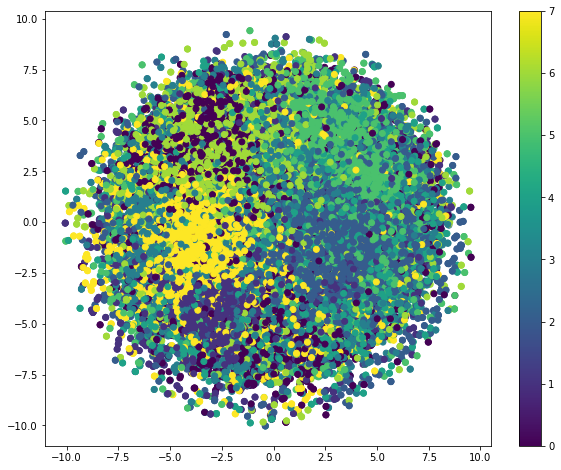

In [ ]:
import matplotlib.pyplot as plt

# Initialize the tSNE model
tsne = TSNE(n_components=2, random_state=317)

# Fit and transform the document vectors to 2D
document_vectors_2d = tsne.fit_transform(document_vectors)

# Plot the clusters
plt.figure(figsize=(10, 8))
plt.scatter(document_vectors_2d[:, 0], document_vectors_2d[:, 1], c=cluster_labels, cmap='viridis')
plt.colorbar()
plt.show()

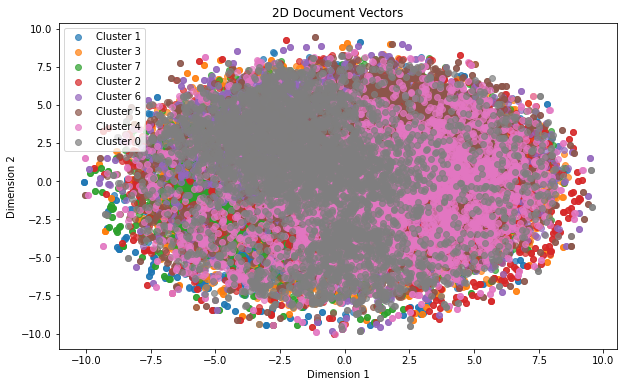

In [ ]:
# Get the unique cluster IDs
unique_clusters = df['cluster'].unique()

# Plot the document vectors
plt.figure(figsize=(10, 6))
for cluster_id in unique_clusters:
    cluster_vectors = document_vectors_2d[df['cluster'] == cluster_id]
    plt.scatter(cluster_vectors[:, 0], cluster_vectors[:, 1], label=f'Cluster {cluster_id}', alpha=0.7)

plt.title('2D Document Vectors')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.legend()
plt.show()
